In [1]:
# import warnings
import rpy2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path, makedirs
from rpy2.robjects.packages import importr
from pandas.plotting import table 

from matplotlib.font_manager import FontProperties
    
from utils import formats, short_names, condition_name_dict, full_passed_turkers #constants
from utils import read_cond_file, violation_analysis, calc_SSRT, filter_ssrt_subs #helper funcs

%load_ext rpy2.ipython

# Constants

In [2]:
TABLE_DIR = 'Tables'
makedirs(TABLE_DIR, exist_ok=True)
TABLE2_DIR = path.join(TABLE_DIR, 'Table2Jasp')
makedirs(TABLE2_DIR, exist_ok=True)
T2_INPUT_DIR = path.join(TABLE2_DIR, 'Input')
makedirs(T2_INPUT_DIR, exist_ok=True)

# Helper Functions

In [3]:
def get_mean_corr_RT(sub_df, trial_type=''):
    assert((trial_type=='GoCritical') | (trial_type=='GoNoncritical') | (trial_type=='Go'))

    # get relevant columns
    rt_col = trial_type+'RT'
    response_col = trial_type+'TrialResponse'
    corr_resp_col = trial_type+'TrialCorrectResponse'
    
    #convert columns to string but leave nans alone
    sub_df[response_col] = np.where(pd.isnull(sub_df[response_col]),sub_df[response_col],sub_df[response_col].astype(str))
    sub_df[corr_resp_col] = np.where(pd.isnull(sub_df[corr_resp_col]),sub_df[corr_resp_col],sub_df[corr_resp_col].astype(str))
    
    #subset to correct answers
    correct_trials = sub_df[sub_df[response_col].str.lower()==sub_df[corr_resp_col].str.lower()] 
    #take mean of correct RTs
    mean_rt = correct_trials[rt_col].mean()

    return(mean_rt)

# __Table 1__

In [4]:
table1_conditions_papers = [
    (['FixedSSDs1'], 'Bissett (2014)'),
    (['FixedSSDs2'], 'Bissett (2014)'),
    (['Deadline1300ms', 'Deadline1500ms', 'Deadline1700ms'], 'Bissett (2014)'),
    (['Deadline2300ms', 'Deadline2500ms', 'Deadline2700ms'], 'Bissett (2014)'),
    (['StopProbabilityLow', 'StopProbabilityHigh'], 'Bissett & Logan (2011)E.1'),
    (['TurkSimpleLow', 'TurkSimpleHigh', 'TurkStimSelec', 'TurkMotorSelec'], 'Eisenberg et al. (2019)'),
    (['Saccades'], 'Bissett (2014)'),
    (['BtwnSubjAuditory1'], 'Bissett & Logan (2012)E.1'),
    (['BtwnSubjAuditory2'], 'Bissett & Logan (2012)E.2'),
    (['BtwnSubjVisual1'], 'Bissett & Logan (2012)E.3'),
    (['BtwnSubjVisual2'], 'Bissett & Logan (2012)E.4'),
    (['BtwnSubjStimSelec'], 'Bissett & Logan (2014)E.1'),
    (['WithinSubjCentralGoSimple', 'WithinSubjCentralGoSelec',
     'WithinSubjPeriphGoSimple', 'WithinSubjPeriphGoSelec'], 'Bissett (2014)'),
    (['Matzke'], 'Matzke et al (2019)')
]

# default = in-person
collection_method_map = {
    'TurkSimpleLow': 'Mechanical Turk',
    'TurkSimpleHigh': 'Mechanical Turk',
    'TurkStimSelec': 'Mechanical Turk',
    'TurkMotorSelec': 'Mechanical Turk',
}

# default = Visual
stop_modality_map = {
    'TurkSimpleLow': 'Visual',
    'TurkSimpleHigh': 'Visual',
    'TurkStimSelec': 'Visual',
    'TurkMotorSelec': 'Visual',
    'BtwnSubjVisual1': 'Visual',
    'BtwnSubjVisual2': 'Visual',
    'Matzke': 'Visual'
}

# default = 'Simple'
stop_rule_map = {
    'TurkStimSelec': 'Stim Selective',
    'TurkMotorSelec': 'Motor Selective',
    'BtwnSubjStimSelec': 'Stim Selective',
    'WithinSubjCentralGoSelec': 'Stim Selective',
    'WithinSubjPeriphGoSelec': 'Stim Selective',
}

table1_data = []
counter = 0
for curr_conds, paper in table1_conditions_papers:
    for check, cond_name in enumerate(curr_conds):
        file = 'Data/Data'+cond_name+'.xlsx'
        curr_df = read_cond_file(file)
        
        counter += 1 #increment condition number

        # get num_subs
        curr_subs = curr_df.Subject.unique()
        if len(curr_subs) == 522: curr_subs = full_passed_turkers
        num_subs = ''
        if check==0:
            num_subs = len(curr_subs)
        # get number of trials for the condition
        max_trials = 0
        for subject in curr_subs:
            max_trials = np.max([max_trials, len(curr_df.query('Subject == %d' % subject))])
            
        #append condition info
        table1_data.append([counter,
                            condition_name_dict[cond_name],
                            num_subs,
                            max_trials,
                            collection_method_map.get(cond_name, 'In-Person'),
                            stop_modality_map.get(cond_name, 'Auditory'),
                            stop_rule_map.get(cond_name, 'Simple'),                    
                            paper])
        
    #append gap row between subject groups
    table1_data.append(['', '', '', '', '', '', '', ''])


table1_df = pd.DataFrame(table1_data, columns=['Condition #', 'Condition Description', 'N', 
                                         'trial N', 'Collection Method', 'Stop Modality', 'Stop Rule', 'Citation'])
table1_df = table1_df.drop([38]) #drop last blank row

table1_df.to_csv(path.join(TABLE_DIR, 'Table1.csv'), index=False)

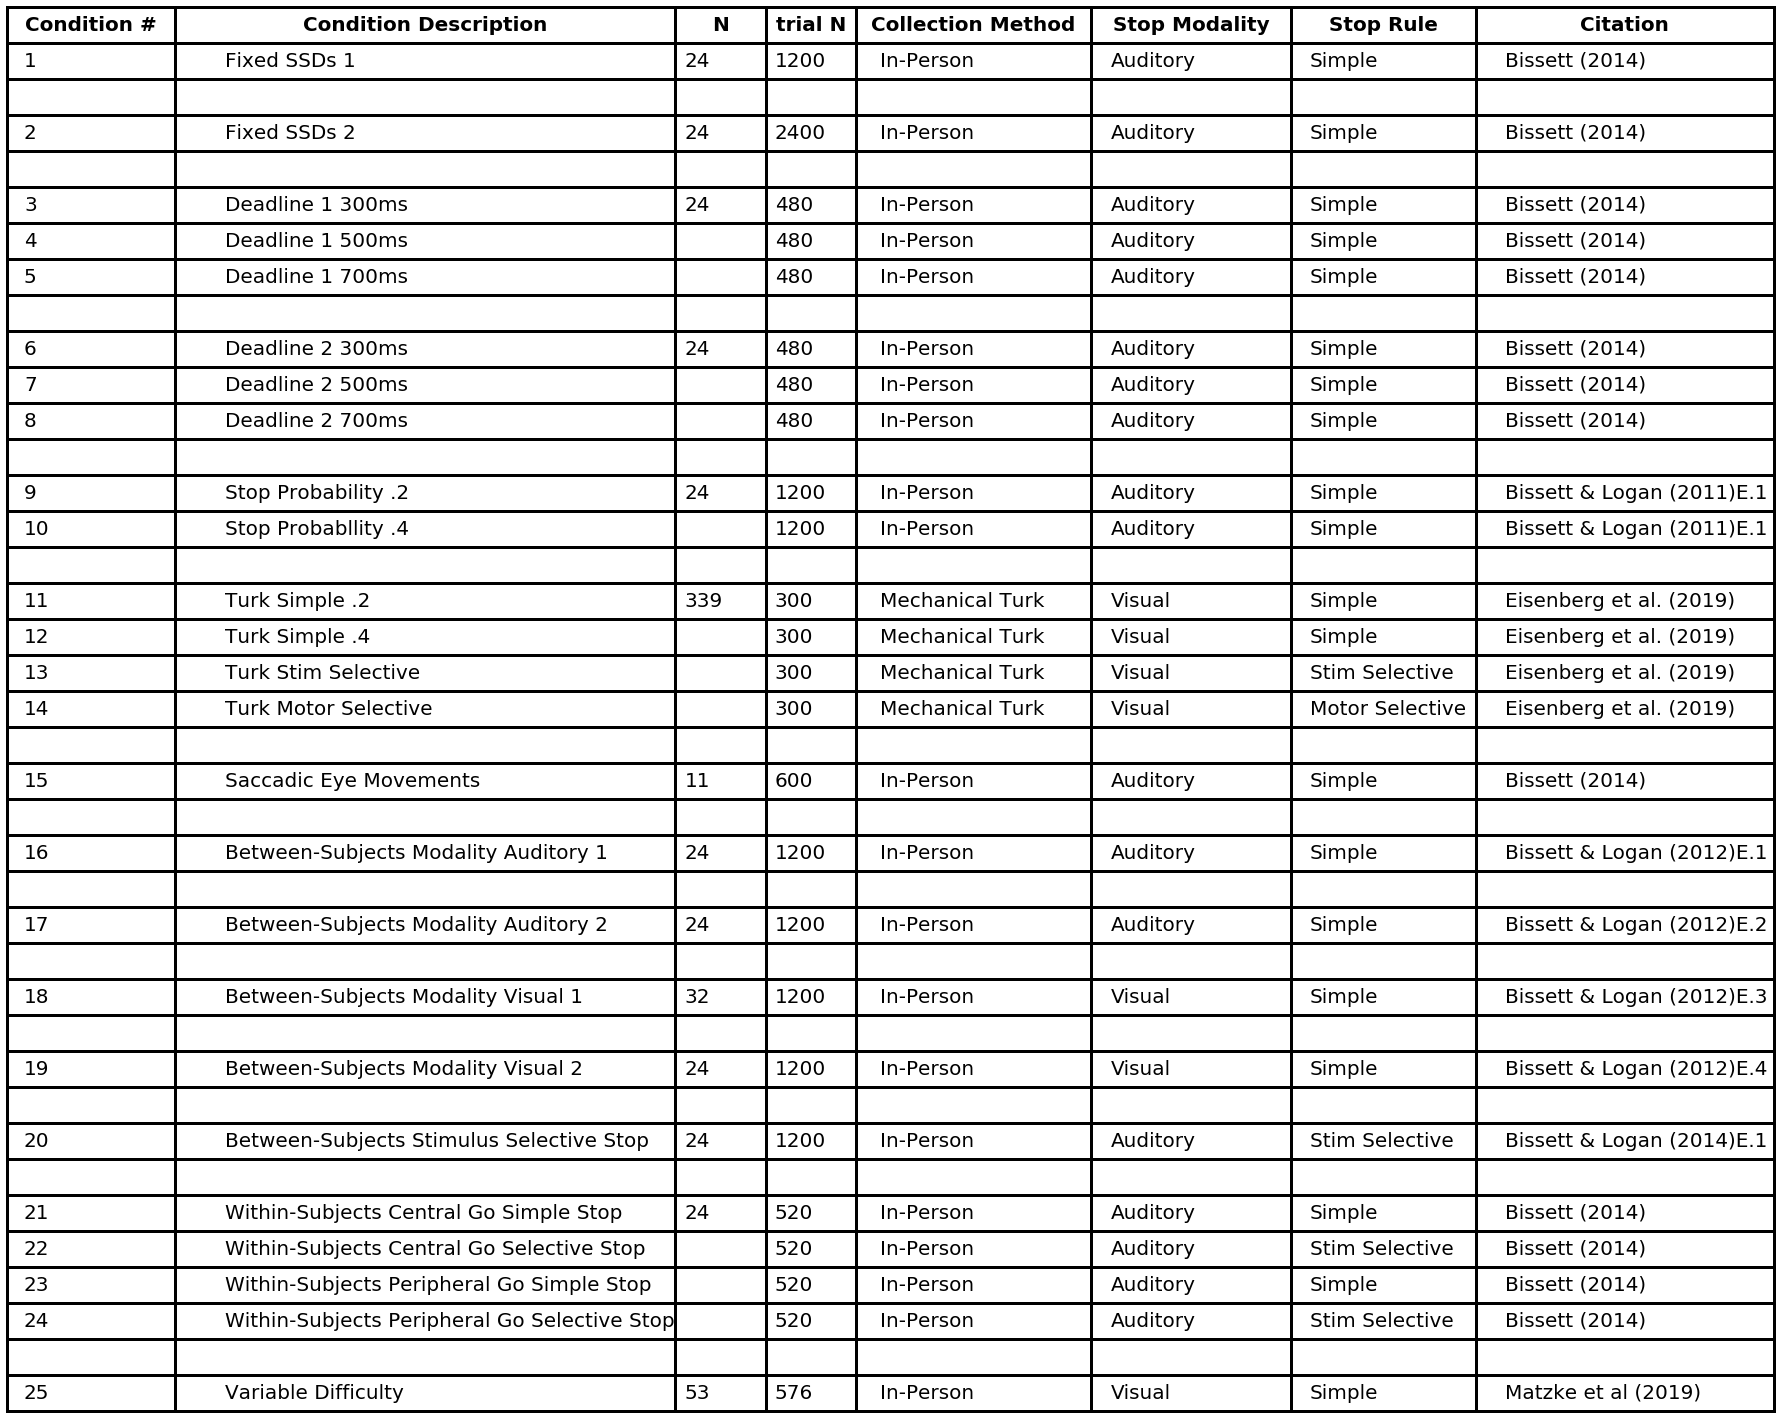

In [5]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table = ax.table(table1_df.values, colLabels=table1_df.columns,
                 loc='center', cellLoc='left',
                 colWidths = [0.25, 0.748, 0.135, 0.135, 0.35, 0.3, 0.275, 0.445], fontsize=20)


for (row, col), cell in table.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

table.auto_set_font_size(False)
table.set_fontsize(20)
table.scale(2, 3)

for key, cell in table.get_celld().items():
    cell.set_linewidth(3)

plt.savefig(path.join(TABLE_DIR, 'Table1.png'), bbox_inches='tight', transparent=True, dpi=600)

# __TABLE 2__

In [6]:
# Initialize Table 2 data frame
table2_df = pd.DataFrame([], columns=['Comparison', 'Condition', 'Violation', 'p-value', 'BF\u2080\u2081', '\u03B7\N{SUPERSCRIPT TWO}'])


# __ROW 1__

In [7]:
cond1_df = read_cond_file('Data/DataFixedSSDs1.xlsx')
cond2_df = read_cond_file('Data/DataFixedSSDs2.xlsx')

#shift cond2 subjects to prevent confusion with cond1 subjs
cond2_df.Subject += cond1_df.Subject.max()

In [8]:
# get median no-stop-signal RT and separate subjects
# Condition 1
Go_RTs1 = []
cond1_subs = cond1_df.Subject.unique()
for subject in cond1_subs:
    subdata = cond1_df.query('Subject == %d' % subject).copy()
    # go RT
    curr_corrRT = get_mean_corr_RT(subdata, trial_type='Go')
    Go_RTs1.append(curr_corrRT)
    
median_RT1 = np.median(Go_RTs1)

slow_idx1 = Go_RTs1 > median_RT1
fast_idx1 = Go_RTs1 < median_RT1

slow_subjects1 = cond1_subs[slow_idx1]
fast_subjects1 = cond1_subs[fast_idx1]

# Conditon 2
Go_RTs2 = []
cond2_subs = cond2_df.Subject.unique()
for subject in cond2_subs:
    subdata = cond2_df.query('Subject == %d' % subject).copy()
    # go RT
    curr_corrRT = get_mean_corr_RT(subdata, trial_type='Go')
    Go_RTs2.append(curr_corrRT)
    
median_RT2 = np.median(Go_RTs2)

slow_idx2 = Go_RTs2 > median_RT2
fast_idx2 = Go_RTs2 < median_RT2

slow_subjects2 = cond2_subs[slow_idx2]
fast_subjects2 = cond2_subs[fast_idx2]


In [9]:
# Generate violation analysis for each condition
VA1_df = violation_analysis(cond1_df)
VA2_df = violation_analysis(cond2_df)

# Process the datasets

#subset to SSDs < 200
VA1_df = VA1_df.loc[VA1_df.ssd < 200, :]
VA2_df = VA2_df.loc[VA2_df.ssd < 200, :]

# #SUBSET TO SHARED SSDs
# shared_ssds = list(set(VA1_df.ssd.unique()).intersection(set(VA2_df.ssd.unique())))
# VA1_df = VA1_df.loc[VA1_df.ssd.isin(shared_ssds), :]
# VA2_df = VA2_df.loc[VA2_df.ssd.isin(shared_ssds), :]

# get mean violation per subject
VA1_means = VA1_df.groupby('subject').mean()
VA2_means = VA2_df.groupby('subject').mean()

#concatenate and clean up
slowVA_mean_df = pd.concat([VA1_means.loc[slow_subjects1].copy(), VA2_means.loc[slow_subjects2].copy()])
fastVA_mean_df = pd.concat([VA1_means.loc[fast_subjects1].copy(), VA2_means.loc[fast_subjects2].copy()])

slowVA_mean_df.dropna(inplace=True)
fastVA_mean_df.dropna(inplace=True)

# add condition label
slowVA_mean_df['condition'] = 'slow'
fastVA_mean_df['condition'] = 'fast'

#move subject into columns
slowVA_mean_df.reset_index(inplace=True)
fastVA_mean_df.reset_index(inplace=True)

#assert no subject overlap
assert((set(slowVA_mean_df.subject.unique())&set(fastVA_mean_df.subject.unique()))==set())


fastSlow_meanVA_df = pd.concat([slowVA_mean_df, fastVA_mean_df])
#remove subject column for JASP and save to csv
del fastSlow_meanVA_df['subject']
fastSlow_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row1SlowFast.csv'), index=False)

/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [10]:
slow_violations = slowVA_mean_df['mean_violation'].values
fast_violations = fastVA_mean_df['mean_violation'].values
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.549
BF_01 = 3.034
eta_sq = 9.846e-4

#build up Table 2
row1 = ['Fast vs. Slow subjects', 'RT Below Median (1/2) vs. RT Above Median (1/2)', f'{fast_violations.mean():.0f}ms vs. {slow_violations.mean():.0f}ms', p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row1
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985


# __ROW 2__

In [11]:
cond3_df = read_cond_file('Data/DataDeadline1300ms.xlsx')
cond4_df = read_cond_file('Data/DataDeadline1500ms.xlsx')
cond5_df = read_cond_file('Data/DataDeadline1700ms.xlsx')
cond6_df = read_cond_file('Data/DataDeadline2300ms.xlsx')
cond7_df = read_cond_file('Data/DataDeadline2500ms.xlsx')
cond8_df = read_cond_file('Data/DataDeadline2700ms.xlsx')

#shifting subjects in conditions 6-8 to keep IDs unique for combined analyses
assert((cond3_df['Subject'].max()==cond4_df['Subject'].max()) & (cond4_df['Subject'].max()==cond5_df['Subject'].max()))

cond6_df['Subject'] = cond6_df['Subject'] + cond5_df['Subject'].max()
cond7_df['Subject'] = cond7_df['Subject'] + cond5_df['Subject'].max()
cond8_df['Subject'] = cond8_df['Subject'] + cond5_df['Subject'].max()

## SUBSET SSDS, THEN SUBJECTS

In [12]:
# Generate violation analysis for each condition
VA3_df = violation_analysis(cond3_df)
VA4_df = violation_analysis(cond4_df)
VA5_df = violation_analysis(cond5_df)
VA6_df = violation_analysis(cond6_df)
VA7_df = violation_analysis(cond7_df)
VA8_df = violation_analysis(cond8_df)

# process Deadline 1 datasets

#subset to SSDs < 200
VA3_df = VA3_df.loc[VA3_df.ssd < 200, :]
VA4_df = VA4_df.loc[VA4_df.ssd < 200, :]
VA5_df = VA5_df.loc[VA5_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA3_df.ssd.unique()).intersection(set(VA4_df.ssd.unique()).intersection(set(VA5_df.ssd.unique()))))
VA3_df = VA3_df.loc[VA3_df.ssd.isin(shared_ssds), :]
VA4_df = VA4_df.loc[VA4_df.ssd.isin(shared_ssds), :]
VA5_df = VA5_df.loc[VA5_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA3_df.subject.unique()).intersection(set(VA4_df.subject.unique()).intersection(set(VA5_df.subject.unique()))))
VA3_df = VA3_df.loc[VA3_df.subject.isin(shared_subs), :]
VA4_df = VA4_df.loc[VA4_df.subject.isin(shared_subs), :]
VA5_df = VA5_df.loc[VA5_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VA3_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA4_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA5_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA3_means = VA3_df.groupby('subject').mean()
VA4_means = VA4_df.groupby('subject').mean()
VA5_means = VA5_df.groupby('subject').mean()

# process Deadline 2 datasets

#subset to SSDs < 200
VA6_df = VA6_df.loc[VA6_df.ssd < 200, :]
VA7_df = VA7_df.loc[VA7_df.ssd < 200, :]
VA8_df = VA8_df.loc[VA8_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA6_df.ssd.unique()).intersection(set(VA7_df.ssd.unique()).intersection(set(VA8_df.ssd.unique()))))
VA6_df = VA6_df.loc[VA6_df.ssd.isin(shared_ssds), :]
VA7_df = VA7_df.loc[VA7_df.ssd.isin(shared_ssds), :]
VA8_df = VA8_df.loc[VA8_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA6_df.subject.unique()).intersection(set(VA7_df.subject.unique()).intersection(set(VA8_df.subject.unique()))))
VA6_df = VA6_df.loc[VA6_df.subject.isin(shared_subs), :]
VA7_df = VA7_df.loc[VA7_df.subject.isin(shared_subs), :]
VA8_df = VA8_df.loc[VA8_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VA6_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA7_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA8_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA6_means = VA6_df.groupby('subject').mean()
VA7_means = VA7_df.groupby('subject').mean()
VA8_means = VA8_df.groupby('subject').mean()

#combine and run ANOVA

#combine like conditions
VA300_mean_df = pd.concat([VA3_means, VA6_means])
VA500_mean_df = pd.concat([VA4_means, VA7_means])
VA700_mean_df = pd.concat([VA5_means, VA8_means])

#assert that the conditions have the same number of subjects
assert((len(VA300_mean_df)==len(VA500_mean_df)) & (len(VA500_mean_df)==len(VA700_mean_df)))

# add condition label
VA300_mean_df['condition'] = '300'
VA500_mean_df['condition'] = '500'
VA700_mean_df['condition'] = '700'

#move subject into columns
VA300_mean_df.reset_index(inplace=True)
VA500_mean_df.reset_index(inplace=True)
VA700_mean_df.reset_index(inplace=True)

#prefix columns and save for JASP input
VA300_mean_df = VA300_mean_df.add_prefix('short_')
VA500_mean_df = VA500_mean_df.add_prefix('intermediate_')
VA700_mean_df = VA700_mean_df.add_prefix('long_')

deadline_meanVA_df = pd.concat([VA300_mean_df, VA500_mean_df, VA700_mean_df], axis=1)
deadline_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row2Deadline.csv'), index=False)

In [13]:
#build up Table 2
violation_300 = VA300_mean_df['short_mean_violation'].mean()
violation_500 = VA500_mean_df['intermediate_mean_violation'].mean()
violation_700 = VA700_mean_df['long_mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.011
BF_01 = 2.478
eta_sq = 0.008

row2 = ['Varying Go Response Deadlines', '300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8)', f'{violation_300:.0f}ms vs. {violation_500:.0f}ms vs. {violation_700:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row2
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000


# Row 3

In [14]:
cond9_df = read_cond_file('Data/DataStopProbabilityLow.xlsx')
cond10_df = read_cond_file('Data/DataStopProbabilityHigh.xlsx')
cond11_df = read_cond_file('Data/DataTurkSimpleLow.xlsx')
cond12_df = read_cond_file('Data/DataTurkSimpleHigh.xlsx')

In [15]:
VA9_df = violation_analysis(cond9_df)
VA10_df = violation_analysis(cond10_df)
VA11_df = violation_analysis(cond11_df)
VA12_df = violation_analysis(cond12_df)

#shift cond11/12 subjects to prevent confusion in the next analysis
assert(VA9_df.subject.max()==VA10_df.subject.max())
VA11_df.subject += VA9_df.subject.max()
VA12_df.subject += VA9_df.subject.max()

In [16]:
# process local datasets

#subset to SSDs < 200
VA9_df = VA9_df.loc[VA9_df.ssd < 200, :]
VA10_df = VA10_df.loc[VA10_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA9_df.ssd.unique()).intersection(set(VA10_df.ssd.unique())))
VA9_df = VA9_df.loc[VA9_df.ssd.isin(shared_ssds), :]
VA10_df = VA10_df.loc[VA10_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA9_df.subject.unique()).intersection(set(VA10_df.subject.unique())))
VA9_df = VA9_df.loc[VA9_df.subject.isin(shared_subs), :]
VA10_df = VA10_df.loc[VA10_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VA9_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA10_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA9_means = VA9_df.groupby('subject').mean()
VA10_means = VA10_df.groupby('subject').mean()


# process turk datasets

#subset to SSDs < 200
VA11_df = VA11_df.loc[VA11_df.ssd < 200, :]
VA12_df = VA12_df.loc[VA12_df.ssd < 200, :]


#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA11_df.subject.unique()).intersection(set(VA12_df.subject.unique())))
VA11_df = VA11_df.loc[VA11_df.subject.isin(shared_subs), :]
VA12_df = VA12_df.loc[VA12_df.subject.isin(shared_subs), :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA11_df.ssd.unique()).intersection(set(VA12_df.ssd.unique())))
VA11_df = VA11_df.loc[VA11_df.ssd.isin(shared_ssds), :]
VA12_df = VA12_df.loc[VA12_df.ssd.isin(shared_ssds), :]


# assert there are still 5 subjects per ssd
assert(VA11_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA12_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA11_means = VA11_df.groupby('subject').mean()
VA12_means = VA12_df.groupby('subject').mean()

#combine and run ANOVA

#combine like conditions
VAlow_mean_df = pd.concat([VA9_means, VA11_means])
VAhigh_mean_df = pd.concat([VA10_means, VA12_means])

#assert that the conditions have the same number of subjects
assert(len(VAlow_mean_df)==len(VAhigh_mean_df))
       
# add condition label
VAlow_mean_df['condition'] = 'low'
VAhigh_mean_df['condition'] = 'high'

#move subject into columns
VAlow_mean_df.reset_index(inplace=True)
VAhigh_mean_df.reset_index(inplace=True)

#save data for JASP input
VAlow_mean_df = VAlow_mean_df.add_prefix('low_')
VAhigh_mean_df = VAhigh_mean_df.add_prefix('high_')
row3_meanVA_df = pd.concat([VAlow_mean_df, VAhigh_mean_df], axis=1)
row3_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row3StopProb.csv'), index=False)

In [17]:
#build up Table 2
violation_low = VAlow_mean_df['low_mean_violation'].mean()
violation_high = VAhigh_mean_df['high_mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.127
BF_01 = 2.582
eta_sq = 0.007

row3 = ['Low vs. High Stop Probability', '.2 (9/11) vs. .4 Stop Probability (10/12)', f'{violation_low:.0f}ms vs. {violation_high:.0f}ms',  p_val, BF_01, eta_sq]

table2_df.loc[len(table2_df)] = row3
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
2,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000


# Row 4

In [18]:
cond15_df = read_cond_file('Data/DataSaccades.xlsx')
# shifting subject IDs to prevent confusion in following analyses
cond15_df.Subject += cond9_df.Subject.max()

In [19]:
VAmanual_df = violation_analysis(cond9_df)
VAsaccade_df = violation_analysis(cond15_df)

In [20]:
# process datasets

#subset to SSDs < 200
VAmanual_df = VAmanual_df.loc[VAmanual_df.ssd < 200, :]
VAsaccade_df = VAsaccade_df.loc[VAsaccade_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VAmanual_df.ssd.unique()).intersection(set(VAsaccade_df.ssd.unique())))
VAmanual_df = VAmanual_df.loc[VAmanual_df.ssd.isin(shared_ssds), :]
VAsaccade_df = VAsaccade_df.loc[VAsaccade_df.ssd.isin(shared_ssds), :]


# assert there are still 5 subjects per ssd
assert(VAmanual_df.groupby('ssd').count()['subject'].min()>=5)
assert(VAsaccade_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VAmanual_mean_df = VAmanual_df.groupby('subject').mean()
VAsaccade_mean_df = VAsaccade_df.groupby('subject').mean()

       
# add condition label
VAmanual_mean_df['condition'] = 'manual'
VAsaccade_mean_df['condition'] = 'saccade'

#move subject into columns
VAmanual_mean_df.reset_index(inplace=True)
VAsaccade_mean_df.reset_index(inplace=True)

#anova
row4_meanVA_df = pd.concat([VAmanual_mean_df, VAsaccade_mean_df])

#remove subjects as save for JASP input
del row4_meanVA_df['subject']
row4_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row4ManualvsSaccade.csv'), index=False)

In [21]:
#build up Table 2
violation_saccade = VAsaccade_mean_df['mean_violation'].mean()
violation_manual = VAmanual_mean_df['mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.754
BF_01 = 3.799
eta_sq = 9.382e-5

row4 = ['Saccadic vs. Manual Responses', 'Saccadic (15) vs. Manual Responses (9)', f'{violation_saccade:.0f}ms vs. {violation_manual:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row4
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
2,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000
3,Saccadic vs. Manual Responses,Saccadic (15) vs. Manual Responses (9),-9ms vs. -3ms,0.754,3.799,0.000094


# Row 5

In [22]:
cond16_df = read_cond_file('Data/DataBtwnSubjAuditory1.xlsx')
cond17_df = read_cond_file('Data/DataBtwnSubjAuditory2.xlsx')
cond18_df = read_cond_file('Data/DataBtwnSubjVisual1.xlsx')
cond19_df = read_cond_file('Data/DataBtwnSubjVisual2.xlsx')

#shift subjects for following analyses
cond17_df['Subject'] += cond16_df['Subject'].max()
cond18_df['Subject'] += cond17_df['Subject'].max()
cond19_df['Subject'] += cond18_df['Subject'].max()

In [23]:
VA16_df = violation_analysis(cond16_df)
VA17_df = violation_analysis(cond17_df)
VA18_df = violation_analysis(cond18_df)
VA19_df = violation_analysis(cond19_df)

In [24]:
# process datasets

#subset to SSDs < 200
VA16_df = VA16_df.loc[VA16_df.ssd < 200, :]
VA17_df = VA17_df.loc[VA17_df.ssd < 200, :]
VA18_df = VA18_df.loc[VA18_df.ssd < 200, :]
VA19_df = VA19_df.loc[VA19_df.ssd < 200, :]

# assert there are 5 subjects per ssd
assert(VA16_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA17_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA18_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA19_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA16_means = VA16_df.groupby('subject').mean()
VA17_means = VA17_df.groupby('subject').mean()
VA18_means = VA18_df.groupby('subject').mean()
VA19_means = VA19_df.groupby('subject').mean()

#concatenate
VAaudio_df = pd.concat([VA16_means, VA17_means])
VAvis_df = pd.concat([VA18_means, VA19_means])
       
# add condition label
VAaudio_df['condition'] = 'audio'
VAvis_df['condition'] = 'visual'

#move subject into columns
VAaudio_df.reset_index(inplace=True)
VAvis_df.reset_index(inplace=True)


#remove subjects as save for JASP input
AV_meanVA_df = pd.concat([VAaudio_df, VAvis_df])
del AV_meanVA_df['subject']
AV_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row5Modality.csv'), index=False)



In [25]:
#build up Table 2
violation_audio = VAaudio_df['mean_violation'].mean()
violation_visual = VAvis_df['mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row5ModalityOutput.jasp
p_val = 0.637
BF_01 = 3.095
eta_sq = 7.657e-4

row5 = ['Auditory vs. Visual Responses', 'Auditory (16/17) vs. Visual Responses (18/19)', f'{violation_audio:.0f}ms vs. {violation_visual:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row5
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
2,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000
3,Saccadic vs. Manual Responses,Saccadic (15) vs. Manual Responses (9),-9ms vs. -3ms,0.754,3.799,0.000094
4,Auditory vs. Visual Responses,Auditory (16/17) vs. Visual Responses (18/19),-22ms vs. -13ms,0.637,3.095,0.000766


# Row 6

In [26]:
cond20_df = read_cond_file('Data/DataBtwnSubjStimSelec.xlsx')

#shifting subject IDs for analysis
cond20_df.Subject += cond9_df.Subject.max()

In [27]:
VAsimple_df = violation_analysis(cond9_df)
VAselective_df = violation_analysis(cond20_df)

In [28]:
# process datasets

#subset to SSDs < 200
VAsimple_df = VAsimple_df.loc[VAsimple_df.ssd < 200, :]
VAselective_df = VAselective_df.loc[VAselective_df.ssd < 200, :]

# assert there are 5 subjects per ssd
assert(VAsimple_df.groupby('ssd').count()['subject'].min()>=5)
assert(VAselective_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VAsimple_df = VAsimple_df.groupby('subject').mean()
VAselective_df = VAselective_df.groupby('subject').mean()

       
# add condition label
VAsimple_df['condition'] = 'simple'
VAselective_df['condition'] = 'selective'

#move subject into columns
VAsimple_df.reset_index(inplace=True)
VAselective_df.reset_index(inplace=True)

#remove subjects as save for JASP input
simpleSelec_meanVA_df = pd.concat([VAsimple_df, VAselective_df])
del simpleSelec_meanVA_df['subject']
simpleSelec_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row6SimplevsSelective.csv'), index=False)

In [29]:
#build up Table 2
violation_simple = VAsimple_df['mean_violation'].mean()
violation_selective = VAselective_df['mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.064
BF_01 = 0.802
eta_sq = 0.018

row6 = ['Stimulus Selective vs. Simple Stopping', 'Stimulus Selective (20) vs. Simple Stopping (9)', f'{violation_selective:.0f}ms vs. {violation_simple:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row6
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
2,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000
3,Saccadic vs. Manual Responses,Saccadic (15) vs. Manual Responses (9),-9ms vs. -3ms,0.754,3.799,0.000094
4,Auditory vs. Visual Responses,Auditory (16/17) vs. Visual Responses (18/19),-22ms vs. -13ms,0.637,3.095,0.000766
5,Stimulus Selective vs. Simple Stopping,Stimulus Selective (20) vs. Simple Stopping (9),55ms vs. -1ms,0.064,0.802,0.018000


# Row 7

In [30]:
cond11_df = read_cond_file('Data/DataTurkSimpleLow.xlsx')
cond12_df = read_cond_file('Data/DataTurkSimpleHigh.xlsx')
cond13_df = read_cond_file('Data/DataTurkStimSelec.xlsx')

cond21_df = read_cond_file('Data/DataWithinSubjCentralGoSimple.xlsx')
cond22_df = read_cond_file('Data/DataWithinSubjCentralGoSelec.xlsx')
cond23_df = read_cond_file('Data/DataWithinSubjPeriphGoSimple.xlsx')
cond24_df = read_cond_file('Data/DataWithinSubjPeriphGoSelec.xlsx')

#shift block nums to prevent block matches
cond12_df.Block += cond11_df.Block.max()
cond23_df.Block += cond21_df.Block.max()
cond24_df.Block += cond22_df.Block.max()

#combine datasets
cond1112_df = pd.concat([cond11_df, cond12_df], ignore_index=True)
cond2123_df = pd.concat([cond21_df, cond23_df], ignore_index=True)
cond2224_df = pd.concat([cond22_df, cond24_df], ignore_index=True)

# Simple Stopping (11/12/21/23)
VA1112_df = violation_analysis(cond1112_df)
VA2123_df = violation_analysis(cond2123_df)

# Stimulus Selective (13/22/24) 
VA13_df = violation_analysis(cond13_df)
VA2224_df = violation_analysis(cond2224_df)

In [31]:
# process turk datasets

#subset to SSDs < 200
VA13_df = VA13_df.loc[VA13_df.ssd < 200, :]
VA1112_df = VA1112_df.loc[VA1112_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA13_df.ssd.unique()).intersection(set(VA1112_df.ssd.unique())))
VA13_df = VA13_df.loc[VA13_df.ssd.isin(shared_ssds), :]
VA1112_df = VA1112_df.loc[VA1112_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA13_df.subject.unique()).intersection(set(VA1112_df.subject.unique())))
VA13_df = VA13_df.loc[VA13_df.subject.isin(shared_subs), :]
VA1112_df = VA1112_df.loc[VA1112_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VA13_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA1112_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA13_means = VA13_df.groupby('subject').mean()
VA1112_means = VA1112_df.groupby('subject').mean()

# process local datasets

#subset to SSDs < 200
VA2224_df = VA2224_df.loc[VA2224_df.ssd < 200, :]
VA2123_df = VA2123_df.loc[VA2123_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VA2224_df.ssd.unique()).intersection(set(VA2123_df.ssd.unique())))
VA2224_df = VA2224_df.loc[VA2224_df.ssd.isin(shared_ssds), :]
VA2123_df = VA2123_df.loc[VA2123_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VA2224_df.subject.unique()).intersection(set(VA2123_df.subject.unique())))
VA2224_df = VA2224_df.loc[VA2224_df.subject.isin(shared_subs), :]
VA2123_df = VA2123_df.loc[VA2123_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VA2224_df.groupby('ssd').count()['subject'].min()>=5)
assert(VA2123_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VA2224_means = VA2224_df.groupby('subject').mean()
VA2123_means = VA2123_df.groupby('subject').mean()
#combine and run ANOVA

#combine like conditions
VAsimple_df = pd.concat([VA1112_means, VA2123_means])
VAselective_df = pd.concat([VA13_means, VA2224_means])

#assert that the conditions have the same number of subjects
assert(len(VAsimple_df)==len(VAselective_df))

# add condition label
VAsimple_df['condition'] = 'simple'
VAselective_df['condition'] = 'selective'

#move subject into columns
VAsimple_df.reset_index(inplace=True)
VAselective_df.reset_index(inplace=True)

#prefix columns and save for JASP input
VAsimple_df = VAsimple_df.add_prefix('simple_')
VAselective_df = VAselective_df.add_prefix('selective_')

simpleSelec_meanVA_df = pd.concat([VAsimple_df, VAselective_df], axis=1)
simpleSelec_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row7SimplevsSelectiveWinSubjs.csv'), index=False)

In [32]:
#build up Table 2
violation_simple = VAsimple_df['simple_mean_violation'].mean()
violation_selective = VAselective_df['selective_mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.018
BF_01 = 0.794
eta_sq = 0.014

row7 = ['Stimulus Selective vs. Simple Stopping', 'Stimulus Selective (13/22/24) vs. Simple Stopping (11/12/21/23)', f'{violation_selective:.0f}ms vs. {violation_simple:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row7
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
0,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
1,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
2,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000
3,Saccadic vs. Manual Responses,Saccadic (15) vs. Manual Responses (9),-9ms vs. -3ms,0.754,3.799,0.000094
4,Auditory vs. Visual Responses,Auditory (16/17) vs. Visual Responses (18/19),-22ms vs. -13ms,0.637,3.095,0.000766
5,Stimulus Selective vs. Simple Stopping,Stimulus Selective (20) vs. Simple Stopping (9),55ms vs. -1ms,0.064,0.802,0.018000
6,Stimulus Selective vs. Simple Stopping,Stimulus Selective (13/22/24) vs. Simple Stopp...,49ms vs. 24ms,0.018,0.794,0.014000


# Row 8

In [33]:
cond14_df = read_cond_file('Data/DataTurkMotorSelec.xlsx')
cond11_df = read_cond_file('Data/DataTurkSimpleLow.xlsx')
cond12_df = read_cond_file('Data/DataTurkSimpleHigh.xlsx')

#shift block nums to prevent block matches
cond12_df.Block += cond11_df.Block.max()

#combine
cond1112_df = pd.concat([cond11_df, cond12_df], ignore_index=True)


In [34]:
VAmotor_df = violation_analysis(cond14_df)
VAsimple_df = violation_analysis(cond1112_df)

In [35]:
# process local datasets

#subset to SSDs < 200
VAmotor_df = VAmotor_df.loc[VAmotor_df.ssd < 200, :]
VAsimple_df = VAsimple_df.loc[VAsimple_df.ssd < 200, :]

#SUBSET TO SHARED SSDs
shared_ssds = list(set(VAmotor_df.ssd.unique()).intersection(set(VAsimple_df.ssd.unique())))
VAmotor_df = VAmotor_df.loc[VAmotor_df.ssd.isin(shared_ssds), :]
VAsimple_df = VAsimple_df.loc[VAsimple_df.ssd.isin(shared_ssds), :]

#SUBSET TO SHARED SUBJECTS
shared_subs = list(set(VAmotor_df.subject.unique()).intersection(set(VAsimple_df.subject.unique())))
VAmotor_df = VAmotor_df.loc[VAmotor_df.subject.isin(shared_subs), :]
VAsimple_df = VAsimple_df.loc[VAsimple_df.subject.isin(shared_subs), :]

# assert there are still 5 subjects per ssd
assert(VAmotor_df.groupby('ssd').count()['subject'].min()>=5)
assert(VAsimple_df.groupby('ssd').count()['subject'].min()>=5)

# get mean violation per subject
VAmotor_df = VAmotor_df.groupby('subject').mean()
VAsimple_df = VAsimple_df.groupby('subject').mean()


#assert that the conditions have the same number of subjects
assert(len(VAmotor_df)==len(VAsimple_df))

# add condition label
VAmotor_df['condition'] = 'motor'
VAsimple_df['condition'] = 'simple'

#move subject into columns
VAmotor_df.reset_index(inplace=True)
VAsimple_df.reset_index(inplace=True)

# #anova
# simpleMotor_meanVA_df = pd.concat([VAsimple_df, VAmotor_df])
# simpleMotor_melt_df = pd.melt(simpleMotor_meanVA_df, id_vars=['subject', 'condition'], value_vars=['mean_stopFailureRT', 'mean_precedingGoRT'], var_name='TrialType', value_name='RT')
# aos_res = pg.rm_anova(dv='RT', within=['TrialType', 'condition'], subject='subject', data=simpleMotor_melt_df)
# aos_res = aos_res.set_index('Source')
# aos_res

#prefix columns and save for JASP input
VAsimple_df = VAsimple_df.add_prefix('simple_')
VAmotor_df = VAmotor_df.add_prefix('motor_')

simpleMotor_meanVA_df = pd.concat([VAsimple_df, VAmotor_df], axis=1)
simpleMotor_meanVA_df.to_csv(path.join(T2_INPUT_DIR, 'row8SimplevsMotor.csv'), index=False)

In [36]:
#build up Table 2
violation_simple = VAsimple_df['simple_mean_violation'].mean()
violation_motor = VAmotor_df['motor_mean_violation'].mean()
# VALUES RETRIEVED FROM TABLE_DIR/row1SlowFastOutput.jasp
p_val = 0.019
BF_01 = 1.467
eta_sq = 0.015

row8 = ['Motor Selective vs. Simple Stopping', 'Motor Selective (14) vs. Simple Stopping (11/12)', f'{violation_motor:.0f}ms vs. {violation_simple:.0f}ms',  p_val, BF_01, eta_sq]
table2_df.loc[len(table2_df)] = row8
table2_df.index += 1 
table2_df.to_csv(path.join(TABLE_DIR, 'Table2.csv'))
table2_df

,Comparison,Condition,Violation,p-value,BF₀₁,η²
1,Fast vs. Slow subjects,RT Below Median (1/2) vs. RT Above Median (1/2),6ms vs. 15ms,0.549,3.034,0.000985
2,Varying Go Response Deadlines,300ms (3/6) vs.500ms (4/7) vs. 700ms (5/8),-16ms vs. -5ms vs. 3ms,0.011,2.478,0.008000
3,Low vs. High Stop Probability,.2 (9/11) vs. .4 Stop Probability (10/12),8ms vs. 27ms,0.127,2.582,0.007000
4,Saccadic vs. Manual Responses,Saccadic (15) vs. Manual Responses (9),-9ms vs. -3ms,0.754,3.799,0.000094
5,Auditory vs. Visual Responses,Auditory (16/17) vs. Visual Responses (18/19),-22ms vs. -13ms,0.637,3.095,0.000766
6,Stimulus Selective vs. Simple Stopping,Stimulus Selective (20) vs. Simple Stopping (9),55ms vs. -1ms,0.064,0.802,0.018000
7,Stimulus Selective vs. Simple Stopping,Stimulus Selective (13/22/24) vs. Simple Stopp...,49ms vs. 24ms,0.018,0.794,0.014000
8,Motor Selective vs. Simple Stopping,Motor Selective (14) vs. Simple Stopping (11/12),69ms vs. 36ms,0.019,1.467,0.015000


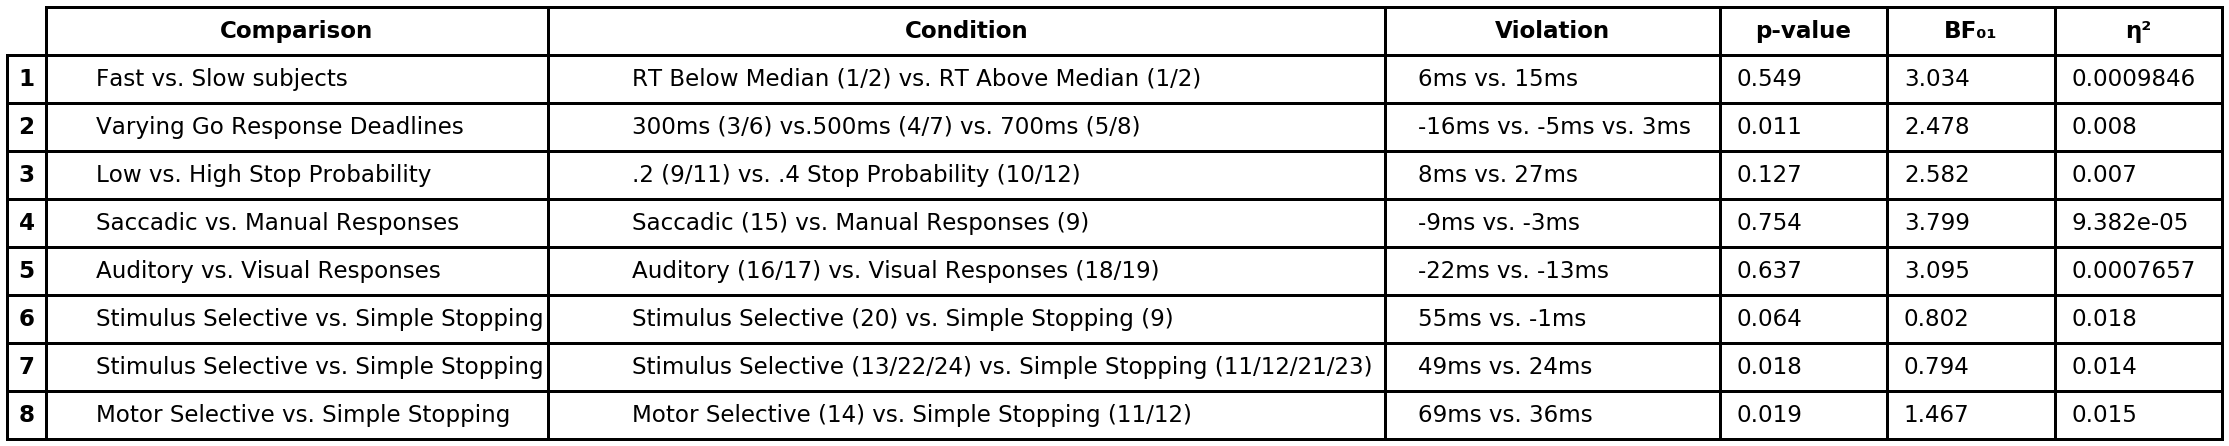

In [37]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table = ax.table(table2_df.values,colLabels=table2_df.columns,
                 loc='center',rowLabels=[' '+str(d)+' ' for d in range(1, len(table2_df.index)+1)],
                 cellLoc='left',
                 colWidths = [0.75, 1.25, 0.5, 0.25, 0.25, 0.25])

for (row, col), cell in table.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

table.auto_set_font_size(False)
table.set_fontsize(23)
table.scale(2, 4)

for key, cell in table.get_celld().items():
    cell.set_linewidth(3)
    
plt.savefig(path.join(TABLE_DIR, 'Table2.png'), bbox_inches='tight', transparent=True, dpi=600)